In [1]:
import numpy as np
import matplotlib.pyplot as plot
import pandas as pd
import time
import gym

from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

%matplotlib inline

In [2]:
class DNNAgent():
    def __init__(self, env, alpha, gamma):
        self.env = env
        self.n_states = env.observation_space.shape[0]
        self.n_actions = env.action_space.n
        self.alpha = alpha
        self.gamma = gamma
        self.policy_model, self.predict_model = self.build_policy_network()
        self.value_model = self.build_value_network()
        
    def build_policy_network(self):
        inputs = Input(shape=(self.n_states,))
        baseline = Input(shape=[1])
        dense1 = Dense(16, activation='relu')(inputs)
        dense2 = Dense(16, activation='relu')(dense1)
        probs = Dense(self.n_actions, activation='softmax')(dense2)

        #negative log likelihood
        def custom_loss(y_true, y_pred): #y_pred is softmax output, y_true is one hot of action taken
            out = K.clip(y_pred, 1e-8, 1-1e-8)
            log_lik = y_true * K.log(out)
            return K.sum(-log_lik * baseline)
        
        policy_model = Model(inputs=[inputs, baseline], outputs=[probs])
        policy_model.compile(optimizer=Adam(lr=self.alpha), loss=custom_loss)
        
        # predict model shares weights with policy model but is used with raw input (no baseline)
        # to get a sofmax (predict) output
        # It doesn't use the custom_loss function because we do not perform backprop and change weight
        predict_model = Model(inputs=[inputs], outputs=[probs])
        return policy_model, predict_model
    
    def build_value_network(self):
        inputs = Input(shape=(self.n_states,))
        dense1 = Dense(16, activation='relu')(inputs)
        dense2 = Dense(16, activation='relu')(dense1)
        value = Dense(1, activation=None)(dense2)  
        value_model = Model(inputs=[inputs], outputs=[value])
        value_model.compile(optimizer=Adam(lr=self.alpha), loss='mse')
        return value_model
        
    def choose_action(self, state):
        softmax = self.predict_model.predict(state[None, :]).flatten()
        action = np.random.choice(range(self.n_actions), p=softmax)
        return action, softmax  
        
    def update_weights(self, states, rewards, actions, states_est):
        total_rewards = []
        for idx in range(len(rewards)):
            discounted_total_reward = sum([(self.gamma**step) * reward 
                                 for step, reward in enumerate(rewards[idx:])])
            total_rewards.append(discounted_total_reward)
        baseline = np.array(total_rewards) - np.array(states_est)
        baseline = np.vstack(baseline)
        one_hot_actions = np.zeros((len(actions), self.n_actions))
        one_hot_actions[range(len(actions)), actions] = 1
        states = np.vstack(states)
        self.policy_model.fit(x=[states, baseline], y=one_hot_actions, verbose=0)
        self.value_model.fit(x=states, y=np.array(total_rewards), verbose=0)

In [12]:
env_name = 'CartPole-v0'
#env_name = 'LunarLander-v2' 
env = gym.make(env_name)

gamma = 0.99
alpha = 0.0001

np.random.seed(1)
agent = DNNAgent(env, alpha, gamma)

In [13]:
highscores = [0]

episode = -1
while np.mean(highscores[-100:]) < 195:
    episode += 1
#for episode in range(7500):
    done = False
    state = env.reset()
    states = []
    states_est = []
    rewards = []
    actions = []
    score = 0
    while not done:
        #env.render() # pop up window showing agent
        
        action, probs = agent.choose_action(state)
        next_state, reward, done, info = env.step(action)
        state_value_est = agent.value_model.predict(state[None, :])
        
        states_est.append(state_value_est)
        states.append(state)
        rewards.append(reward)
        actions.append(action)
        
        state = next_state
        score += reward
        
    agent.update_weights(states, rewards, actions, states_est)
    
    highscores.append(score)
    print(f'episode: {episode} highscores: {np.mean(highscores[-100:])}', end="\r", flush=False)    
        
env.close() # closes popup window

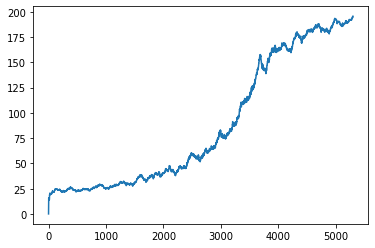

In [14]:
pd.Series(highscores).rolling(window=100, min_periods=1).mean().plot()

In [30]:
test_highscores = []
for episode in range(10):
    done = False
    state = env.reset()
    score = 0
    while not done:
        env.render() # pop up window showing agent
        
        action, probs = agent.choose_action(state)
        state, reward, done, info = env.step(action)
        
        score += reward
    
    test_highscores.append(score)
    
env.close()
test_highscores 

[200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0]